### Этап 5. Выбор технологий и подходов для реализации проекта

Технология детекции лица на фотографии/видео
Для целей распознавая наличия медицинской маски на человеке необходимо сначала ограничить область поиска маски. В нашем случае мы ее будем искать на лице. Данный подход позволит, во-первых, снизить время расчета по модели, во-вторых снизить требования к аппаратному обеспечению (вычислительному), а также исключить потенциальную возможность обнаружения медицинской маски в иных местах (нас такие значения не интересуют).
Два основных подхода к обнаружению лиц:
* классический каскадный классификатор на основе признаков-фильтров (метод  Виолы-Джонса);
* совместное обнаружение и выравнивание лиц с использованием многозадачных каскадных сверточных сетей.
Первый подход реализуется через библиотеку OpenCV, второй — через библиотеки DLIB. MTCNN и др. Ниже представлен сравнительный анализ подходов:

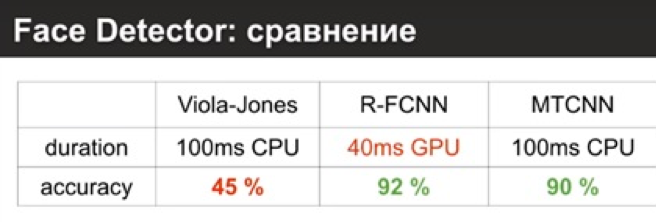

В рамках проекта посмотрим, как работают оба этих метода. В части каскадного классификатора будем использовать каскад Хаара (haarcascadefrontalface) а в части многозадачных сетей будем использовать решение от MTCNN.

#### Технологии захвата и работы с потоковым видео
Для работы с потоковым видео в данном проекте будет использоваться библиотека OpenCV. Данная библиотека позволяет работать с изображениями, совершать преобразования. Работа с видео будет осуществлена следующим образом: 1 кард – это картинка, соответственно, чтобы работать с потоковым видео необходимо создать бесконечный цикл картинок (кадров), а также предусмотреть выход из этого цикла по команде. Захват видео будет осуществляться с встроенной камеры ноутбука.

In [1]:
import tensorflow 
from keras.models import load_model
import cv2
import numpy as np
from mtcnn import MTCNN

Загрузим ранее полученную в проекте модель.

In [2]:
model = load_model('/Users/alexrassomagin/projects/skillfactory_rds/final project/mask_recogn2_two_classes.hdf5')

#### Сначала реализуем требуемы функционал с помощью каскада

In [3]:
face_clsfr=cv2.CascadeClassifier('/Users/alexrassomagin/projects/skillfactory_rds/final project/haarcascade_frontalface_default.xml')
source=cv2.VideoCapture(0)
labels_dict={0:'MASK', 1:'NO MASK' }
color_dict={0:(0,255,0), 1:(255,0,0)}

In [4]:
while(True):

    ret,img=source.read()
    image=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    faces=face_clsfr.detectMultiScale(image,1.3,5)  
    
    for (x, y, w, h) in faces:     
        face_img=image[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(224,224))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,224,224,3))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

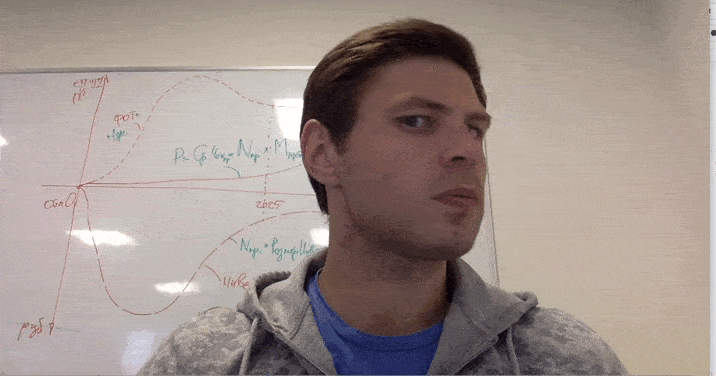

Данный метод работае достаточно быстро, видео не тормозит, лицо определяется четко. При этом у данного метода есть существенный недостаток: лицо определяется только в фронтальном положении к камере. Данный недостаток обусловлен использованием соответствующего каскада Хаара.

#### Реализуем необходимый функционал с помощью MTCNN

In [3]:
source=cv2.VideoCapture(0)
detector = MTCNN() 
labels_dict={0:'MASK', 1:'NO MASK' }
color_dict={0:(0,255,0), 1:(255,0,0)}

In [4]:
while(True):

    ret,img=source.read() 
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(image)

    
    for face in faces:     
        x, y, w, h = face['box']
        face_img=img[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(224,224))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,224,224,3))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

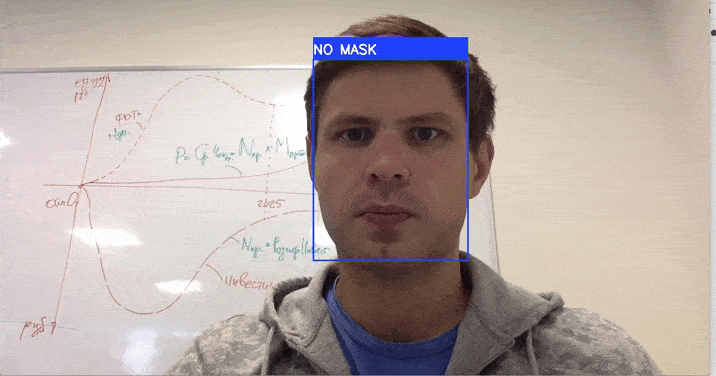

Данный метод работает заметно медленнее, есть "тормоза" по видео. При этом лицо определяется в любых положениях за счет определения его по "следящим" точкам.

### Выводы к проекту

В рамках данного проекта поставленная задача была полностью решена. Достигнуты результаты различными методами, которые имеют свои плюсы и минусы, а их выбор полностью зависит от реальной поставленной задачи.

В развитии данного проекта можно задуматься об оптимизации скорости работы функционала, а также о